<a href="https://colab.research.google.com/github/JayBaileyCS/RLAlgorithms/blob/main/DDPG_From_Scratch_Atari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gym
!pip install pybullet
!pip install git+https://github.com/DLR-RM/stable-baselines3

In [ ]:
import random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import copy
import time
from psutil import virtual_memory
import pybullet_envs

In [ ]:
# Instantiate the neural networks
class Actor(nn.Module):
  def __init__(self, env):
    super().__init__()
    self.network = nn.Sequential(
        nn.Linear(np.array(env.single_observation_space.shape).prod(), 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, np.prod(env.single_action_space.shape)),
    )
    self.register_buffer("action_scale", torch.FloatTensor((env.single_action_space.high - env.single_action_space.low) / 2.0))
    self.register_buffer("action_bias", torch.FloatTensor((env.single_action_space.high + env.single_action_space.low) / 2.0))
  
  def forward(self, x):
    return torch.tanh(self.network(x)) * self.action_scale + self.action_bias

class DeepQNetwork(nn.Module):
  def __init__(self, env):
    super().__init__()
    self.network = nn.Sequential(
        nn.Linear(np.array(env.single_observation_space.shape).prod() + np.prod(env.single_action_space.shape), 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 1)
    )

  def forward(self, x, a):
    return self.network(torch.cat([x, a], 1))

In [ ]:
# Instantiate the replay buffer.
class ReplayBuffer:

  def __init__(self, max_frames):
    self.max_frames = max_frames
    self.buffer = np.zeros_like([0 for i in range(max_frames)], dtype=object)
    self.index = 0

  def add(self, frame):
    frame["index"] = [self.index]
    self.buffer[self.index % self.max_frames] = frame
    self.index = self.index + 1

  def sample(self, num_samples):
    experiences = np.random.randint(0, min(self.index-1, self.max_frames-1), size=num_samples)
    experiences = np.random.choice(self.buffer[0:min(self.index-1, self.max_frames-1)], size=[num_samples], replace=True)
    return {"obs": self.transform(experiences, "obs", torch.float32, [num_samples, 15]),
            "next_obs": self.get_next_obs_batch(experiences),
            "actions": self.transform(experiences, "action", torch.float32, [num_samples, 3]),
            "rewards": self.transform(experiences, "reward", torch.float32, [num_samples, 1]),
            "dones": self.transform(experiences, "done", torch.float32, [num_samples, 1])}

  def transform(self, array, key, dtype, shape):
      item = [item[key] for item in array]
      item = np.array(item)
      item = torch.as_tensor(item, dtype=dtype)
      return item.reshape(shape)

  def get_next_obs_batch(self, experiences):
    indices = [experience["index"][0] if experience["done"][0] > 0 else experience["index"][0] + 1 for experience in experiences]
    next_obs_batch = [self.buffer[index % self.max_frames]["obs"] for index in indices]
    return torch.as_tensor(np.array(next_obs_batch), dtype=torch.float32).reshape(len(indices), 15)

In [ ]:
def make_env(env_id, seed):
    def thunk():
        env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env.seed(seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env
    return thunk

In [ ]:
# Helper functions
def plot_results(steps, rewards, total_timesteps, avg, benchmark):
  plt.plot([item for item in get_rolling_average(steps, avg)], 
          [item for item in get_rolling_average(rewards, avg)])
  max_x = [0, total_timesteps]
  max_y = [benchmark, benchmark] # Cartpole max.
  plt.plot(max_x, max_y, color='r', ls=':')
  plt.xlabel(f"Number of Steps (Avg. {avg})")
  plt.ylabel(f"Current Return (Avg. {avg})")
  plt.show()

def get_rolling_average(items, num):
    rolling = []
    for i in range(len(items)-num):
        rolling.append(sum(items[i:i+num])/num)
    return rolling

def print_colab_info():
  # Print GPU and RAM info for Colab instance.
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
  else:
    print(gpu_info)
  ram_gb = virtual_memory().total / 1e9
  print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

In [ ]:
def train(env, total_timesteps, batch_size, buffer_size, seed, gamma, tau, 
          learning_rate, exploration_noise, policy_frequency, learn_start_size):
  
  env = gym.vector.SyncVectorEnv([make_env(env, seed)])
  assert isinstance(env.single_action_space, gym.spaces.Box), "only continuous action space is supported"
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  print(device)
  print_colab_info()

  writer = SummaryWriter(f"runs/test")
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True if seed > 0 else False

  # Initialise replay memory D to capacity N
  buffer = ReplayBuffer(buffer_size)

  # Initialize action-value function Q and target network.
  actor = Actor(env).to(device)
  target_actor = Actor(env).to(device)
  target_actor.load_state_dict(actor.state_dict())
  q_network = DeepQNetwork(env).to(device)
  target_network = DeepQNetwork(env).to(device)
  target_network.load_state_dict(q_network.state_dict())
  q_optimiser = torch.optim.Adam(list(q_network.parameters()), learning_rate)
  actor_optimiser = torch.optim.Adam(list(actor.parameters()), learning_rate)

  obs = env.reset()
  episode_end_steps = []
  episode_rewards = []
  start_time = time.time()

  for step in range(total_timesteps):

    if step < learn_start_size:
      action = np.array([env.single_action_space.sample() for _ in range(env.num_envs)])
    else:
      with torch.no_grad():
        action = actor(torch.Tensor(obs).to(device)) # This part is questionable.
        action += torch.normal(actor.action_bias, actor.action_scale * exploration_noise)
        action = action.cpu().numpy().clip(env.single_action_space.low, env.single_action_space.high)

    next_obs, reward, done, info = env.step(action)
    next_obs_copy = next_obs.copy()

    # Store transition in D.
    buffer.add({"obs": obs, "action": action, "reward": [reward], "done": [1. if done else 0.]})
    
    if done and "episode" in info[0].keys():
        print(f"global_step={step}, episodic_return={int(info[0]['episode']['r'])}")
        writer.add_scalar("charts/episodic_return", info[0]["episode"]["r"], step)
        writer.add_scalar("charts/episodic_length", info[0]["episode"]["l"], step)
        episode_end_steps.append(step)
        episode_rewards.append(info[0]['episode']['r'])
        obs = env.reset()
        continue

    obs = next_obs

    if step > learn_start_size:
    
      # Sample replay experiences.
      experiences = buffer.sample(batch_size)
      experiences = {i:j.to(device) for (i, j) in experiences.items()}

      with torch.no_grad(): # We want to sample the Q-network here, but not update it yet.
        next_state_actions = target_actor(experiences["next_obs"])
        target = target_network(experiences["next_obs"], next_state_actions)
        next_q_value = experiences["rewards"].flatten() + (1 - experiences["dones"].flatten()) * gamma * (target).view(-1)

      q_action_values = q_network(experiences["obs"], experiences["actions"]).view(-1)

      # Calculate loss
      q_loss = F.mse_loss(q_action_values, next_q_value)

      # Gradient descent
      q_optimiser.zero_grad()
      q_loss.backward()
      q_optimiser.step()

      if step % policy_frequency == 0:
        actor_loss = -q_network(experiences["obs"], actor(experiences["obs"])).mean()
        actor_optimiser.zero_grad()
        actor_loss.backward()
        actor_optimiser.step()

        for param, target_param in zip(q_network.parameters(), target_network.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        for param, target_param in zip(actor.parameters(), target_actor.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

      # Logs
      if step % 1000 == 0:
          writer.add_scalar("losses/qf1_loss", q_loss.item(), step)
          writer.add_scalar("losses/actor_loss", actor_loss.item(), step)
          writer.add_scalar("losses/qf1_values", q_action_values.mean().item(), step)
          print("SPS:", int(step / (time.time() - start_time)))
          writer.add_scalar("charts/SPS", int(step / (time.time() - start_time)),step)

  env.close()
  writer.close()
  plot_results(episode_end_steps, episode_rewards, total_timesteps, 50, 168)

train(env='HopperBulletEnv-v0', total_timesteps=1000000, batch_size=256, buffer_size=100000, seed=1, gamma=0.99, tau=0.005, learning_rate=3e-4, exploration_noise=0.1, policy_frequency=2, learn_start_size=25000)

CleanRL comparison. CleanRL up top, this code on the bottom.

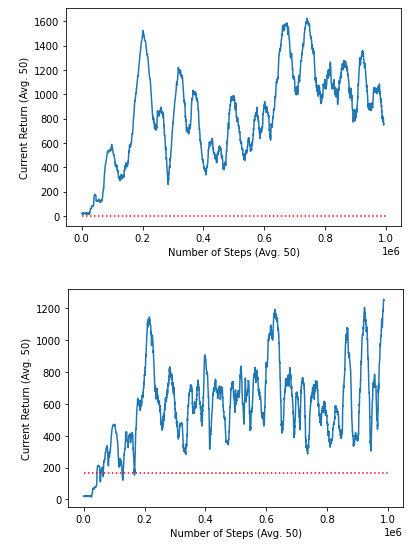